# PGA Tour Machine Learning

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Cleaning the Data

In [4]:
# Import data
df = pd.read_csv("./ASA All PGA Raw Data - Tourn Level.csv")
df.head()

,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,...,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Hadwin,401353275,5548,284,283,57.0,51.3,62,0,1.8,...,15.0,2022,1,T44,-0.56,0.23,-0.03,-0.13,0.06,-0.50
1,A. Noren,401353275,3832,284,285,47.0,43.3,62,3,1.8,...,15.0,2022,1,T52,0.99,-0.09,-1.63,-0.28,-1.99,-1.00
2,A. Putnam,401353275,5502,284,279,65.0,61.1,66,3,7.6,...,15.0,2022,1,T23,1.30,0.49,-0.27,-1.01,-0.80,0.50
3,A. Scott,401353275,388,284,274,77.5,72.7,75,0,5.6,...,15.0,2022,1,T5,0.70,0.28,0.27,0.50,1.05,1.75
4,A. Smalley,401353275,9484,284,283,59.5,54.0,59,3,11.8,...,15.0,2022,1,T44,-0.23,-1.08,1.31,-0.49,-0.27,-0.50


In [5]:
# Remove and rename columns 
columns = ['player', 'course', 'date', 'player id', 'hole_par', 'strokes', 'n_rounds', 'made_cut', 'purse', 'season', 'no_cut', 'sg_putt',
'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'pos']

df = df[columns]

df = df.rename(columns={"player id": "player_id"})

In [6]:
# Drop all rows with na values in an sg category (revisit in future)
df = df.dropna(subset=['sg_total', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g'])

In [8]:
# Make nan values in position the max value
max_score_series = df.groupby('course')['pos'].max()
df['pos'] = df['pos'].fillna(df['course'].map(max_score_series))

In [13]:
# Create a series with each player_id assigned to player name
# This is used to map a player to his player_id in later steps
player_df = df[['player', 'player_id']].drop_duplicates()
player_series = player_df.set_index('player_id')['player']

In [15]:
df.head()

,player,course,date,player_id,hole_par,strokes,n_rounds,made_cut,purse,season,no_cut,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,pos
0,Adam Hadwin,"Wilmington Country Club - Wilmington, DE",2022-08-21,5548,284,283,4,1,15.0,2022,1,-0.56,0.23,-0.03,-0.13,0.06,-0.50,44.0
1,Alexander Noren,"Wilmington Country Club - Wilmington, DE",2022-08-21,3832,284,285,4,1,15.0,2022,1,0.99,-0.09,-1.63,-0.28,-1.99,-1.00,52.0
2,Andrew Putnam,"Wilmington Country Club - Wilmington, DE",2022-08-21,5502,284,279,4,1,15.0,2022,1,1.30,0.49,-0.27,-1.01,-0.80,0.50,23.0
3,Adam Scott,"Wilmington Country Club - Wilmington, DE",2022-08-21,388,284,274,4,1,15.0,2022,1,0.70,0.28,0.27,0.50,1.05,1.75,5.0
4,Alex Smalley,"Wilmington Country Club - Wilmington, DE",2022-08-21,9484,284,283,4,1,15.0,2022,1,-0.23,-1.08,1.31,-0.49,-0.27,-0.50,44.0


## Visualizing the Data

<AxesSubplot:>

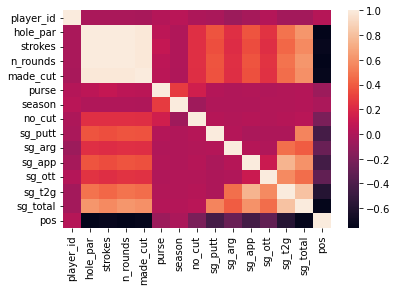

In [28]:
sns.heatmap(df.corr())

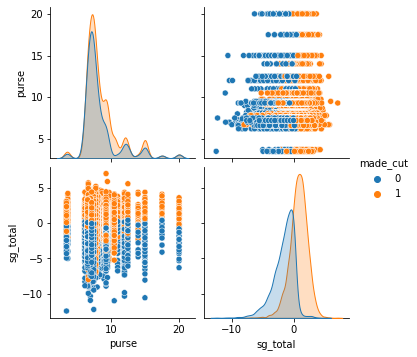

In [29]:
sns.pairplot(data=df,
             vars=['purse', 'sg_total'],
             hue='made_cut')

## Finding the Model

In [30]:
# Drop the date and player name for the model
df = df.drop(columns=['player', 'date'])

In [31]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['made_cut']):
    training_set = df.loc[df.index.intersection(train_index)]
    testing_set = df.loc[df.index.intersection(test_index)] 

In [32]:
X_train = training_set.drop('pos', axis=1)
y_train = training_set['pos'].copy()
X_test = testing_set.drop('pos', axis=1)
y_test = testing_set['pos'].copy()

In [33]:
num_attribs = list(X_train.select_dtypes(include=[np.number]))
cat_attribs = list(X_train.select_dtypes(exclude=[np.number]))

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [34]:
# from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    ]

In [35]:
# for name, clf in zip(names, classifiers):
#     clf.fit(X_train_prepared, y_train)
#     y_pred = clf.predict(X_test_prepared)
#     # evaluate predictions
#     accuracy = clf.score(X_test_prepared, y_test)
#     print("%s Accuracy: %.2f%%" % (name, accuracy * 100.0))

## Training the Neural Net

In [20]:
clf = MLPClassifier(alpha=1, max_iter=1000)
clf.fit(X_train_prepared, y_train)
y_pred = clf.predict(X_test_prepared)

In [39]:
accuracy = clf.score(X_test_prepared, y_test)
print(f"Accuracy: {round(accuracy*100, 2)}%")

Accuracy: 50.13%


In [40]:
data = {'player_id': [], 'course' : [], 'season' : [], 'pos': []}
for i, pred in enumerate(y_pred):
    pId = X_test['player_id'].iloc[i]
    course = X_test['course'].iloc[i]
    season = X_test['season'].iloc[i]
    data['player_id'].append(pId)
    data['course'].append(course)
    data['season'].append(season)
    data['pos'].append(pred)

In [59]:
prediction_df = pd.DataFrame(data)
prediction_df['player'] = prediction_df['player_id'].map(player_series)

In [60]:
prediction_df

,player_id,course,season,pos,player
0,3832,"Wilmington Country Club - Wilmington, DE",2022,48.0,Alexander Noren
1,10058,"Wilmington Country Club - Wilmington, DE",2022,48.0,Davis Riley
2,10166,"Wilmington Country Club - Wilmington, DE",2022,35.0,J.J. Spaun
3,5467,"Wilmington Country Club - Wilmington, DE",2022,28.0,Jordan Spieth
4,4848,"Wilmington Country Club - Wilmington, DE",2022,48.0,Justin Thomas
...,...,...,...,...,...
2233,6151,"Riviera Country Club - Pacific Palisades, CA",2020,51.0,Martin Trainer
2234,1600,"Riviera Country Club - Pacific Palisades, CA",2020,75.0,Nate Lashley
2235,3792,"Riviera Country Club - Pacific Palisades, CA",2020,75.0,Nick Taylor
2236,6007,"Riviera Country Club - Pacific Palisades, CA",2020,18.0,Patrick Cantlay
